<a href="https://colab.research.google.com/github/Diyon335/PRA3024/blob/master/Week5_Jacco/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import cifar
import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict

def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)  

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

In [3]:
#Load data samples
x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


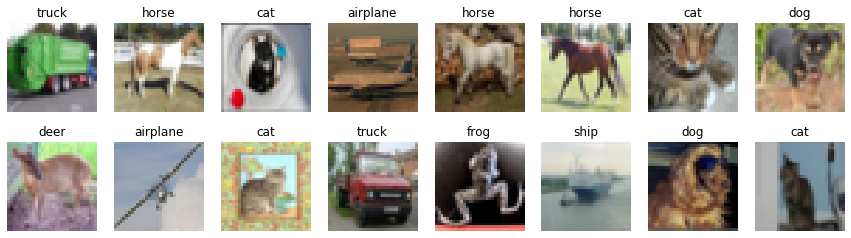

In [4]:
#This shows some random images with their labels
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [0]:
#one-hot encode
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_val = keras.utils.to_categorical(y_val, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [0]:
#import necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [0]:
#This method returns my model

def make_model():

    model = Sequential()
    #The following network was inspired by sagar448
    """
    https://github.com/sagar448/Keras-Convolutional-Neural-Network-Python/blob/master/Convolutional%20Neural%20Network%20for%20Object%20Recognition.py#L42
    """
    #Makes a Conv 2D with 3x3 kernels
    #Dimensional input = output
    #Sets 20% of nodes to 0
    model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3), padding='same',
                 activation='relu'))
    model.add(Dropout(0.2))

    #Add another layer
    model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))

    #Flatten our data
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    return model

In [21]:
#initial learning rate
INIT_LR = 5e-3 
BATCH_SIZE = 32
EPOCHS = 100

K.clear_session()  
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 12s 311us/step - loss: 1.6758 - acc: 0.3945 - val_loss: 1.3802 - val_acc: 0.5094
Epoch 2/100
40000/40000 [==============================] - 12s 299us/step - loss: 1.3093 - acc: 0.5354 - val_loss: 1.2550 - val_acc: 0.5612
Epoch 3/100
40000/40000 [==============================] - 12s 299us/step - loss: 1.1618 - acc: 0.5912 - val_loss: 1.0935 - val_acc: 0.6126
Epoch 4/100
40000/40000 [==============================] - 12s 299us/step - loss: 1.0718 - acc: 0.6203 - val_loss: 1.0955 - val_acc: 0.6183
Epoch 5/100
40000/40000 [==============================] - 12s 297us/step - loss: 0.9904 - acc: 0.6521 - val_loss: 1.0434 - val_acc: 0.6402
Epoch 6/100
40000/40000 [==============================] - 12s 297us/step - loss: 0.9271 - acc: 0.6742 - val_loss: 1.0114 - val_acc: 0.6527
Epoch 7/100
40000/40000 [==============================] - 12s 300us/step - loss: 0.8770 - acc: 0.6919 - val_l

In [0]:
# load weights from file 
model.load_weights("weights.h5")

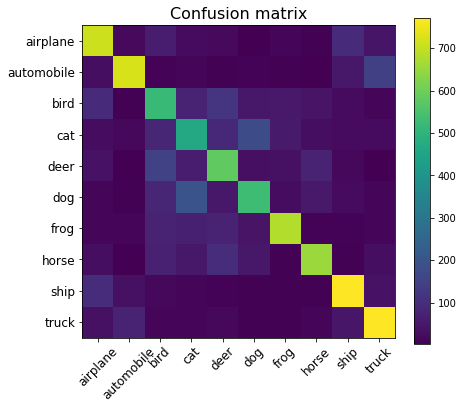

Test accuracy: 0.6408


In [25]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

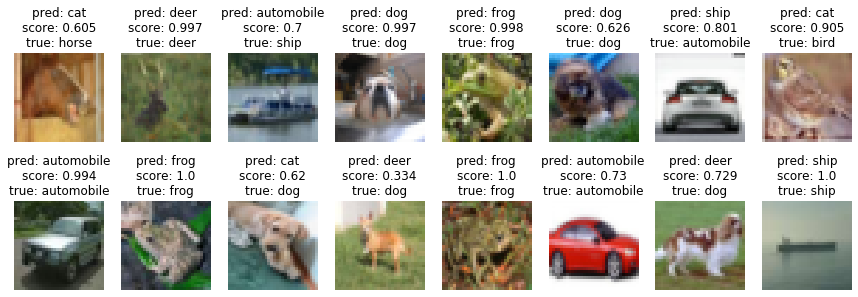

In [28]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()